In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import joblib
from utils.subtractive_clustering import SubtractiveClustering
from sklearn.neighbors import NearestNeighbors
from utils.reliability_visualizer import ReliabilityVisualizer

from utils.grace_classifier import GRACEClassifier

df_grace = pd.read_excel("dataset/data_validation.xlsx")

In [2]:
grace_classifier = GRACEClassifier()

def make_prediction(row):
    return grace_classifier.predict(
        age=row['Idade'],
        heart_rate=row['FC_admissao'],
        systolic_bp=row['PAS_admissao'],
        creatinine=row['Creatininaadmissao'],
        killip_class=row['Killip_maximo'],
        cardiac_arrest=row['Killip_entrada'],
        st_deviation=row['STEMI'],
        elevated_markers=row['Troponin_admissao']
    )

df_grace['Predicted'] = df_grace.apply(make_prediction, axis=1)


y_true = df_grace['Morte']
y_pred = df_grace['Predicted']

confusion_matrix(y_true, y_pred)

#[TN FP]
#[FN TP]


array([[60, 34],
       [ 7, 36]])

# Pointwise Subtractive

In [3]:
###########################################################
# Load Classifier and Data
###########################################################
pipeline = joblib.load('lr_pipeline_classifier.pkl')   # TODO: Just to make the data scaling 
training_data = pd.read_excel("dataset/data_train.xlsx")

y_train = training_data['Morte']
X_train = training_data.drop(columns=['Morte'])

X_train_preprocessed = pipeline.named_steps['preprocessor'].transform(X_train)

In [4]:
###########################################################
# Subtractive Clustering - Grid Search
###########################################################

cluster_influence_ranges = np.linspace(0.02, 0.5, 40)
min_members_per_cluster = 3  # Minimum members required in every cluster

results = []
for influence_range in cluster_influence_ranges:
    clustering = SubtractiveClustering(cluster_influence_range=influence_range)
    cluster_centers = clustering.fit(X_train_preprocessed)
    
    # Assign points to clusters
    threshold = influence_range
    cluster_members = {}
    for i, point in enumerate(X_train_preprocessed):
        distances_to_centers = np.linalg.norm(cluster_centers - point, axis=1)
        closest_cluster = np.argmin(distances_to_centers)
        if distances_to_centers[closest_cluster] <= threshold:
            if closest_cluster not in cluster_members:
                cluster_members[closest_cluster] = []
            cluster_members[closest_cluster].append(i)

    valid_clusters = True
    for cluster_idx, members in cluster_members.items():
        if len(members) < min_members_per_cluster:
            valid_clusters = False
            break  # No need to check further, this configuration is invalid

    if valid_clusters:
        n_clusters = len(cluster_members)
        max_samples = max(len(members) for members in cluster_members.values()) if n_clusters > 0 else 0
        results.append({
            "influence_range": influence_range,
            "n_clusters": n_clusters,
            "max_samples": max_samples
        })

results_df = pd.DataFrame(results)

# Find the influence range that maximizes the number of clusters
if not results_df.empty:
    best_params = results_df.loc[results_df['n_clusters'].idxmax()]
    best_influence_range = best_params['influence_range']
    best_max_samples = best_params['max_samples']
    best_n_clusters = best_params['n_clusters']

    print("Best Parameters to Maximize Valid Clusters:")
    print(f"Influence Range: {best_influence_range}")
    print(f"Max Samples in a Cluster: {best_max_samples}")
    print(f"Number of Clusters: {best_n_clusters}")

Best Parameters to Maximize Valid Clusters:
Influence Range: 0.06923076923076923
Max Samples in a Cluster: 26.0
Number of Clusters: 26.0


In [5]:
###########################################################
# Train
###########################################################

##################################
###### TODO: Ajdust
# my_cluster_influence_range=0.2
my_cluster_influence_range=best_influence_range # Influence range for assigning points to clusters
threshold = my_cluster_influence_range  # Influence range for assigning points to clusters

clustering = SubtractiveClustering(cluster_influence_range=my_cluster_influence_range)
cluster_centers = clustering.fit(X_train_preprocessed)

cluster_members = {}
for i, point in enumerate(X_train_preprocessed):
    distances_to_centers = np.linalg.norm(cluster_centers - point, axis=1)
    closest_cluster = np.argmin(distances_to_centers)
    if distances_to_centers[closest_cluster] <= my_cluster_influence_range:
        if closest_cluster not in cluster_members:
            cluster_members[closest_cluster] = []
        cluster_members[closest_cluster].append(i)

In [6]:
###########################################################
# Reliability Calculation
###########################################################

def calculate_reliability_with_subtractive(new_instance, cluster_centers, cluster_members, threshold, min_cluster_units):
    """
    Calculate reliability of a new instance based on subtractive clustering.

    Parameters:
    - new_instance: Preprocessed new instance.
    - cluster_centers: Identified cluster centers.
    - cluster_members: Members of each cluster.
    - threshold (float): Distance threshold for cluster membership.
    - min_cluster_units (int): Minimum number of points required for full reliability.

    Returns:
    - reliability_score: Reliability score based on cluster size.
    - in_cluster: Boolean indicating if the instance is part of a cluster.
    """
    # Find the nearest cluster center
    distances = np.linalg.norm(cluster_centers - new_instance, axis=1)
    closest_cluster = np.argmin(distances)

    # Check if within threshold
    if distances[closest_cluster] <= threshold:
        cluster_size = len(cluster_members[closest_cluster])
        reliability_score = min(cluster_size / min_cluster_units, 1.0)
        return reliability_score, True
    else:
        return 0, False

def classify_and_check_reliability_subtractive(new_data, pipeline, cluster_centers, cluster_members, threshold, min_cluster_units):
    """
    Predicts the class, determines cluster membership, and calculates reliability.

    Parameters:
    - new_data (pd.DataFrame): DataFrame with the same columns as training data.
    - pipeline (Pipeline): The loaded pipeline for preprocessing and classification.
    - cluster_centers: Identified cluster centers.
    - cluster_members: Members of each cluster.
    - threshold (float): Distance threshold for cluster membership.
    - min_cluster_units (int): Minimum number of points required for full reliability.

    Returns:
    - dict: Contains prediction, cluster membership, and reliability score.
    """
    new_data_preprocessed = pipeline.named_steps['preprocessor'].transform(new_data)

    # Using Grace:
    # predicted_label = pipeline.named_steps['classifier'].predict(new_data_preprocessed)[0]

    new_data_row = new_data.iloc[0]  # Extract the first (and only) row


    predicted_label = grace_classifier.predict(
                        age=new_data_row['Idade'],
                        heart_rate=new_data_row['FC_admissao'],
                        systolic_bp=new_data_row['PAS_admissao'],
                        creatinine=new_data_row['Creatininaadmissao'],
                        killip_class=new_data_row['Killip_maximo'],
                        cardiac_arrest=new_data_row['Killip_entrada'],
                        st_deviation=new_data_row['STEMI'],
                        elevated_markers=new_data_row['Troponin_admissao']
                    )


    reliability_score, in_cluster = calculate_reliability_with_subtractive(
        new_data_preprocessed[0], cluster_centers, cluster_members, threshold, min_cluster_units
    )

    return {
        "predicted_label": predicted_label,
        "reliability_score": reliability_score,
        "in_cluster": in_cluster
    }

In [7]:
###########################################################
# Load Validation Data and Test
###########################################################
validation_data = pd.read_excel("dataset/data_validation.xlsx")

results = []

###############
### TODO: Adjust
min_cluster_units = 9  # Minimum points for full reliability

for _, instance in validation_data.iterrows():
    true_label = instance['Morte']
    instance_df = pd.DataFrame([instance.drop(labels=['Morte'])])
    result = classify_and_check_reliability_subtractive(
        instance_df, pipeline, cluster_centers, cluster_members, threshold, min_cluster_units
    )
    result['true_label'] = true_label
    results.append(result)

# Filter results where reliability_score > 0
filtered_results = [result for result in results if result['reliability_score'] > 0]

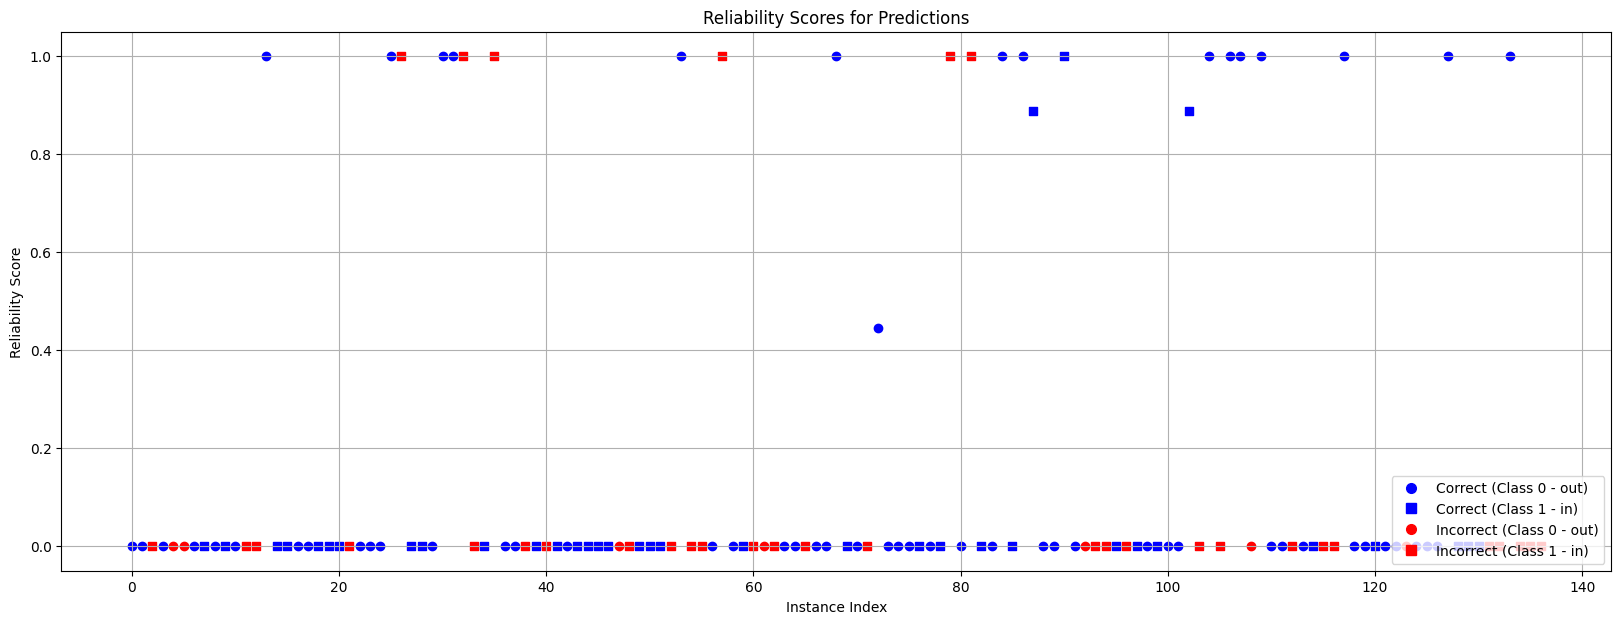

In [8]:
###########################################################
# Results and Visualization
###########################################################
results_df = pd.DataFrame(results)

visualizer = ReliabilityVisualizer(results_df=results_df)
visualizer.plot_reliability_scores((20, 7))

In [9]:
reliability_table_df = visualizer.get_reliability_table_5()

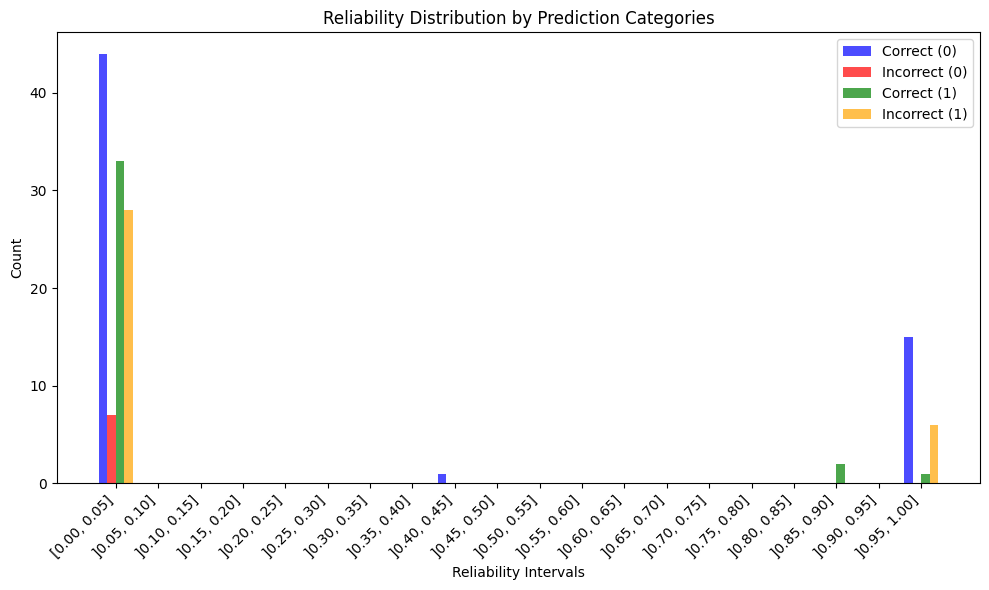

In [10]:
visualizer.plot_table_graph(reliability_table_df)

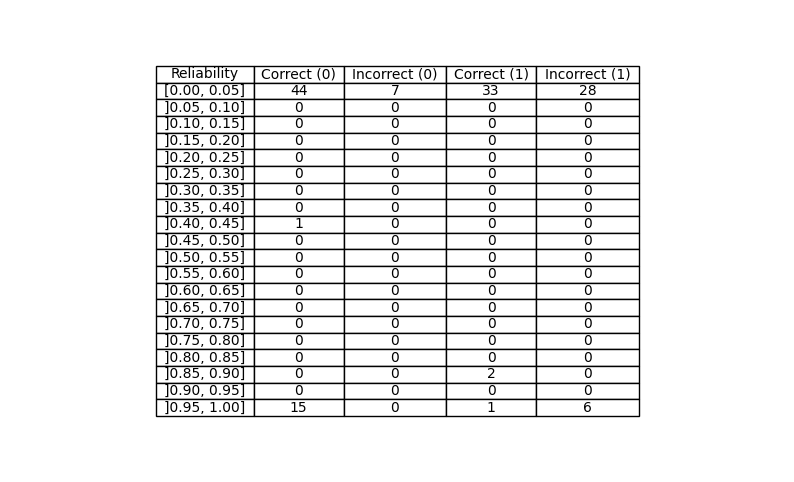

In [11]:
visualizer.plot_table_image(reliability_table_df)

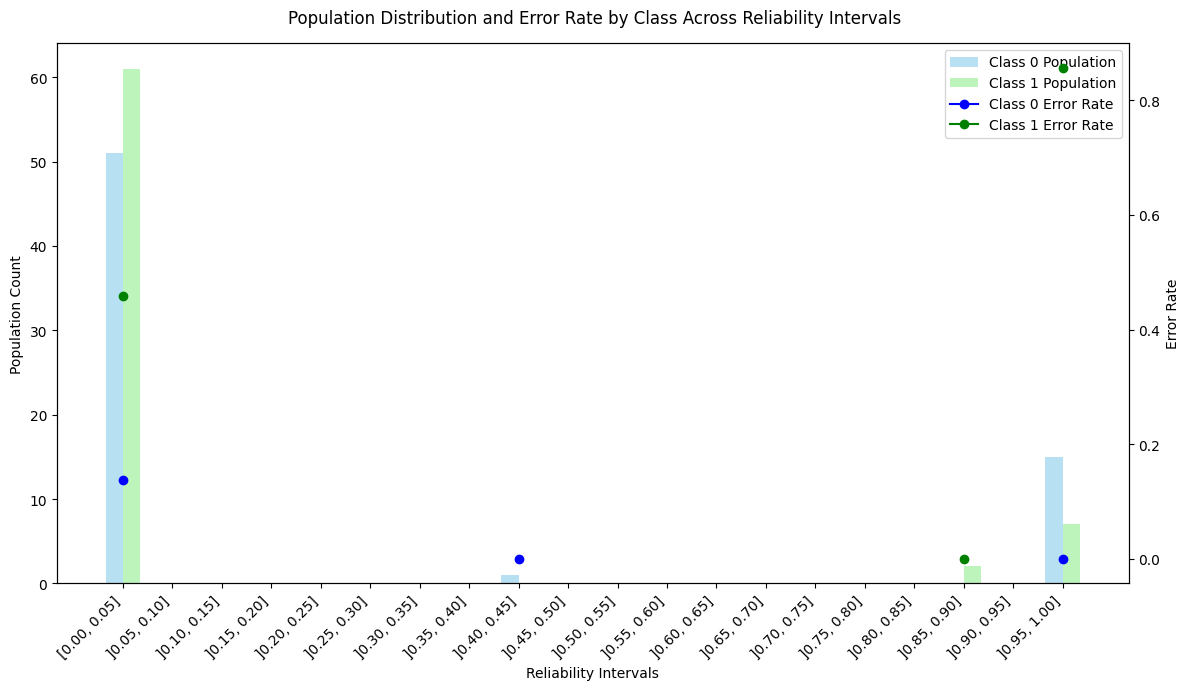

In [12]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_df)

### 10

In [13]:
reliability_table_10_df = visualizer.get_reliability_table_10()
print(reliability_table_10_df)

    Reliability  Correct (0)  Incorrect (0)  Correct (1)  Incorrect (1)
0  [0.00, 0.10]           44              7           33             28
1  ]0.10, 0.20]            0              0            0              0
2  ]0.20, 0.30]            0              0            0              0
3  ]0.30, 0.40]            0              0            0              0
4  ]0.40, 0.50]            1              0            0              0
5  ]0.50, 0.60]            0              0            0              0
6  ]0.60, 0.70]            0              0            0              0
7  ]0.70, 0.80]            0              0            0              0
8  ]0.80, 0.90]            0              0            2              0
9  ]0.90, 1.00]           15              0            1              6


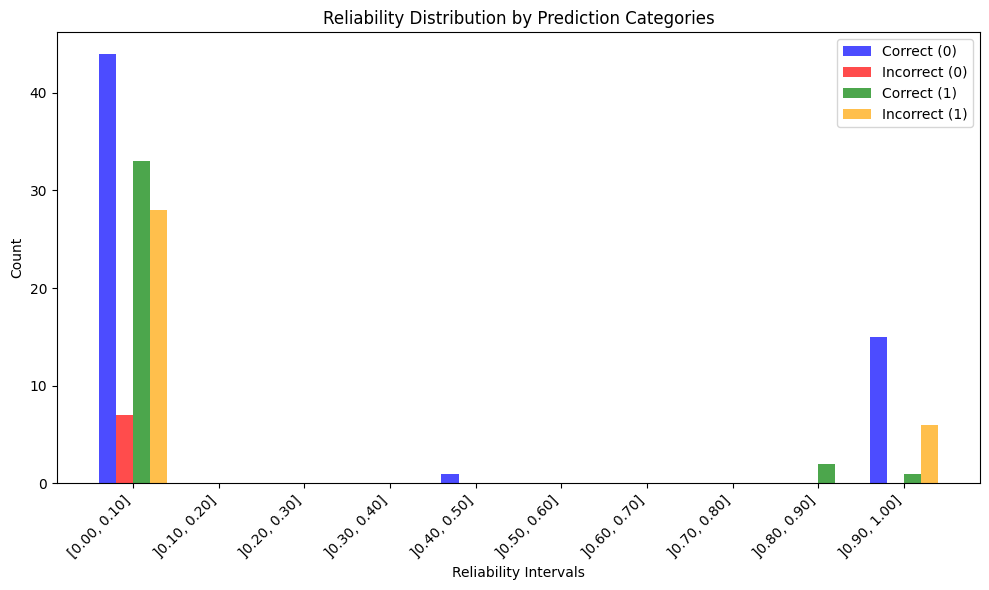

In [14]:
visualizer.plot_table_graph(reliability_table_10_df)

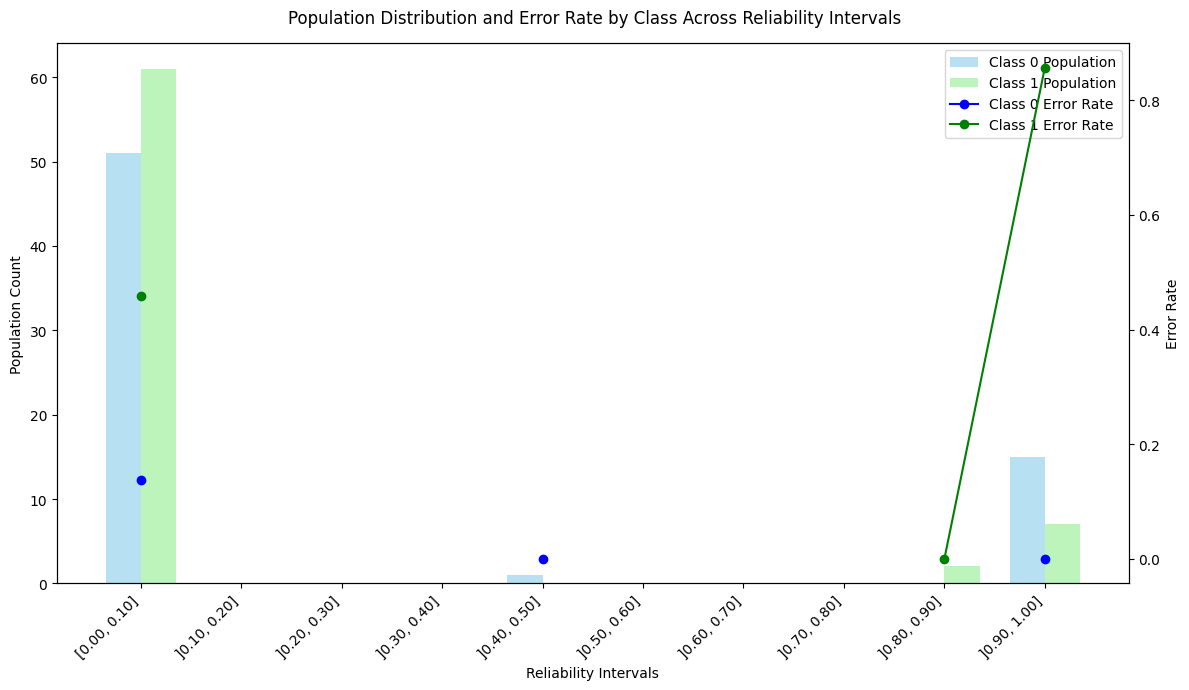

In [15]:
visualizer.plot_population_and_error_rate_by_class(reliability_table_10_df)

Sample reliability interval assignment:
   reliability_score reliability_interval
0                0.0        (-0.001, 0.1]
1                0.0        (-0.001, 0.1]
2                0.0        (-0.001, 0.1]
3                0.0        (-0.001, 0.1]
4                0.0        (-0.001, 0.1]
5                0.0        (-0.001, 0.1]
6                0.0        (-0.001, 0.1]
7                0.0        (-0.001, 0.1]
8                0.0        (-0.001, 0.1]
9                0.0        (-0.001, 0.1]


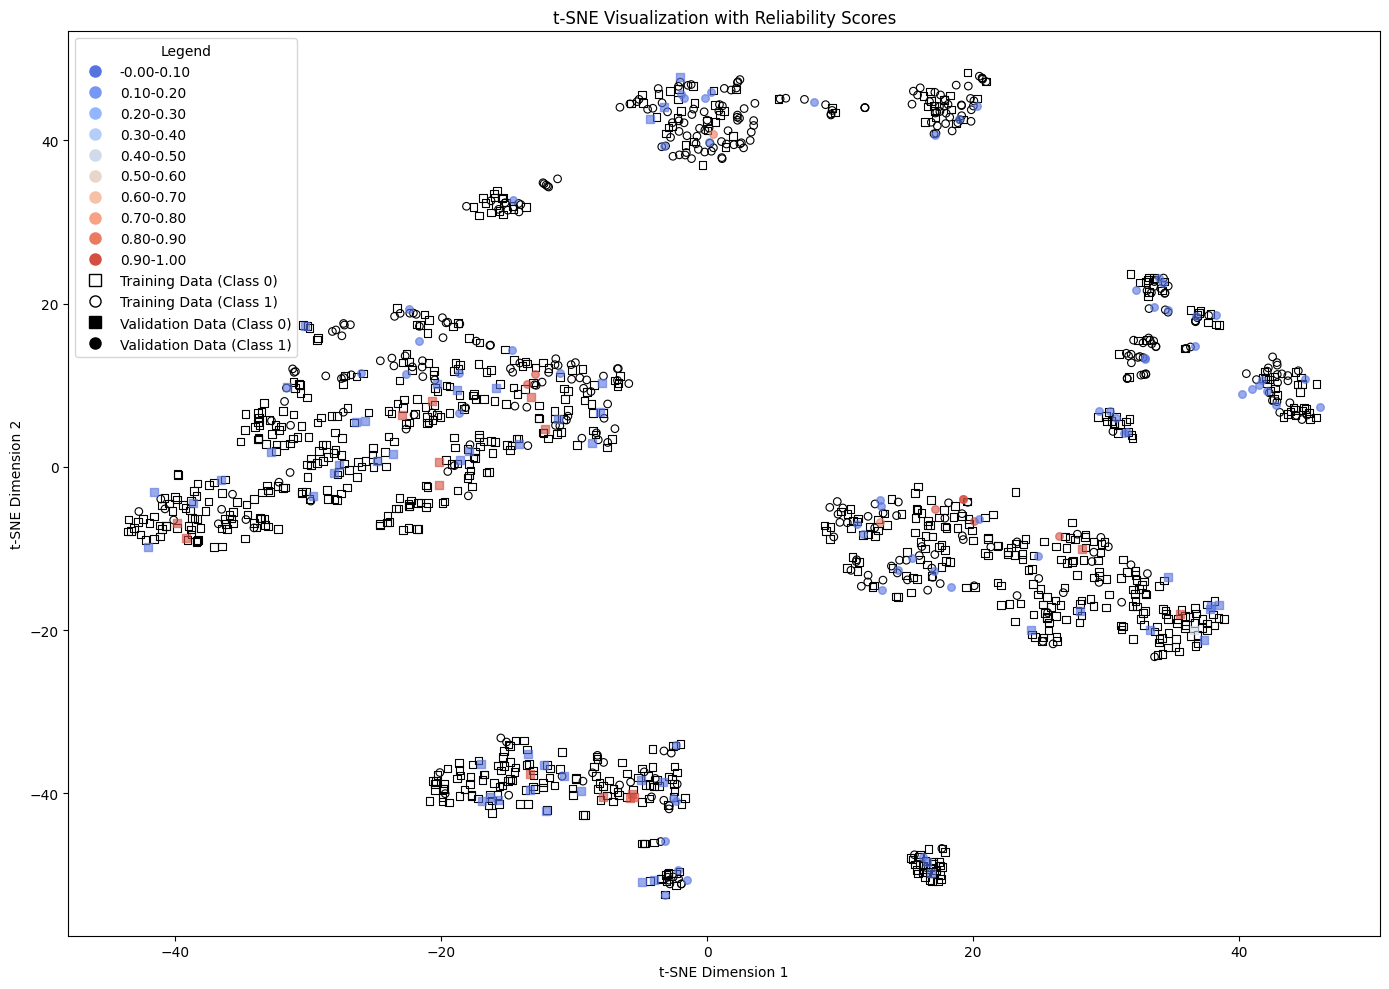

In [16]:
visualizer.plot_tsne_with_reliability(
    X_train_preprocessed, validation_data, y_train, pipeline
)